<a href="https://colab.research.google.com/github/TheConstant3/android-classifier/blob/master/MobileClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Распознавание кошки на изображении**

**Выбор датасета**

Одним из наиболее популярных общедоступных датасетов для задачи классификации изображений является [ImageNet](https://www.image-net.org/) (ILSVRC2010), он же часто используется как эталон для сравнения показателей точности различных архитектур. Данный датасет включает в себя 1000 категорий экземпляров, в том числе различные породы кошек, а общее число изображений составляет около 1,2 миллиона изображений.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) также является популярным датасетом, содержащим экземпляры с изображением кошек. Данный набор имеет по 6000 изображений в каждом из 10 классов. 

Ещё одним популярным датасетом, содержащим изображения кошек является [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip), который содержит 25000 изображений кошек и собак.

Для решения поставленной задачи нейросеть должна не только обучиться определять кошку на изображении, но и отличать её от других объектов, что не позволит достичь обучение на датасете Dogs vs. Cats. 

Так же важным условием является определение **домашней** кошки, так как, например, кошка и тигр имеют много схожих признаков (уши, лапы, усы и др.). В датасете CIFAR-10 экземпляры домашних и диких кошек не определены, как разные объекты, поэтому использование CIFAR-10 не будет корректным. Также, данный датасет имеет изображения с очень низким разрешением.

Использование ImageNet является наиболее правильным, но возникает проблема с объёмом памяти, занимаемым этим набором (~150GB). Эту проблему можно решить с помощью инструмента [ImageNet-Datasets-Downloader](https://github.com/mf1024/ImageNet-Datasets-Downloader), загружая определенное количество изображений каждого класса.

**Выбор архитектурой нейронной сети.** 

Опираясь на показатели из источников [1](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite) и [2](https://www.tensorflow.org/lite/guide/hosted_models), можно сделать вывод о том, что лучшие показатели точности Top-1 имеют модели архитектур efficientnet-lite4(int8), Inception_V4_quant, NASNet large с 80.2%, 79.5% и 82.6% точностями соответственно. Но последняя модель имеет гораздо больший размер и время обработки, поэтому она не будет использоваться. Inception_V4_quant занимает время обработки 4 батчей на CPU - 268 ms, в то время как efficientnet-lite4 30ms.

Таким образом, efficientnet-lite4 будет использована для решения поставленной задачи.

## Подготовка датасета

In [1]:
!git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git

Cloning into 'ImageNet-Datasets-Downloader'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 117 (delta 0), reused 1 (delta 0), pack-reused 113
Receiving objects: 100% (117/117), 1.57 MiB | 3.01 MiB/s, done.
Resolving deltas: 100% (64/64), done.


ImageNet содержит более 20 тысяч классов, которые распределены по подгруппам. Структуру классификации можно посмотреть с помощью [WordNet hierarchy](http://image-net.org/explore.php). В данной иерархии имеются общие классы, напимер domestic cat, и более подробные, например Egyptian cat, которые являются их подклассами.

Для поставленной задачи будет правильно загрузить все общие классы, кроме животных, и из общего класса животных загрузить классы не домашних кошек для класса "не кошка". Для класса "кошка" загрузить изображения всех подклассов домашней кошки.  

In [0]:
import os

os.mkdir('imagenet')
os.mkdir('imagenet/cat')
os.mkdir('imagenet/not_cat')

In [3]:
ANIMAL = '''\
invertebrate,\
homeotherm,\
work animal,\
darter,\
survivor,\
range animal,\
creepy-crawly,\
dog, domestic dog,\
head,\
stray,\
stocker,\
feeder,\
molter, moulter,\
varmint, varment,\
mutant,\
critter,\
game,\
young, offspring,\
poikilotherm,\
herbivore,\
peeper,\
pest,\
female,\
insectivore,\
zooplankton,\
pleurodont,\
mate,\
giant,\
racer,\
migrator, \
prey, quarry,\
omnivore,\
stayer,\
fictional animal,\
male'''

DOMESTIC_CATS = 'domestic cat,Egyptian cat,Persian cat,kitty,tiger cat,tom,Siamese cat,Manx,Maltese,Burmese cat,alley cat,Abyssinian'

OTHER = 'artifact,artefact,sport,natural object,natural object,fungus,person,individual,someone,somebody,mortal,soul,wilding'

animals = ANIMAL.split(',')
cats = DOMESTIC_CATS.split(',')
other = OTHER.split(',')

print(animals)
print(cats)
print(other)

['invertebrate', 'homeotherm', 'work animal', 'darter', 'survivor', 'range animal', 'creepy-crawly', 'dog', ' domestic dog', 'head', 'stray', 'stocker', 'feeder', 'molter', ' moulter', 'varmint', ' varment', 'mutant', 'critter', 'game', 'young', ' offspring', 'poikilotherm', 'herbivore', 'peeper', 'pest', 'female', 'insectivore', 'zooplankton', 'pleurodont', 'mate', 'giant', 'racer', 'migrator', ' prey', ' quarry', 'omnivore', 'stayer', 'fictional animal', 'male']
['domestic cat', 'Egyptian cat', 'Persian cat', 'kitty', 'tiger cat', 'tom', 'Siamese cat', 'Manx', 'Maltese', 'Burmese cat', 'alley cat', 'Abyssinian']
['artifact', 'artefact', 'sport', 'natural object', 'natural object', 'fungus', 'person', 'individual', 'someone', 'somebody', 'mortal', 'soul', 'wilding']


In [4]:
import pandas as pd

animal_class_list = []
cat_class_list = []
other_class_list = []

classes = pd.read_csv('ImageNet-Datasets-Downloader/classes_in_imagenet.csv')

for name in animals:
  syn_id = classes.loc[classes['class_name'] == name]['synid'].values.tolist()
  animal_class_list.extend(syn_id)
  
for name in cats:
  syn_id = classes.loc[classes['class_name'] == name]['synid'].values.tolist()
  cat_class_list.extend(syn_id)
  
for name in other:
  syn_id = classes.loc[classes['class_name'] == name]['synid'].values.tolist()
  other_class_list.extend(syn_id)

print('классов с животными (не кошками)', len(animal_class_list))
animal_class_list = ' '.join(map(str, animal_class_list))
print(animal_class_list)

print('классов с кошками', len(cat_class_list))
cat_class_list = ' '.join(map(str, cat_class_list))
print(cat_class_list)
print('классов с другими объектами', len(other_class_list))
other_class_list = ' '.join(map(str, other_class_list))
print(other_class_list)


классов с животными (не кошками) 50
n01905661 n01315330 n01316949 n01314910 n10681194 n01315805 n01314781 n02084071 n01318381 n03501288 n03501520 n03501614 n05538625 n02122580 n01318053 n01317813 n01317916 n01318660 n01324305 n01314663 n02152991 n03413828 n01321579 n01315581 n01324610 n01315213 n01314388 n10419630 n01320872 n09619168 n01324799 n01889074 n01384164 n01325060 n07926785 n10300041 n10300154 n10300303 n12757668 n01323781 n01730812 n02384858 n04037443 n01318478 n02075612 n10377542 n01319001 n02451575 n01321230 n09624168
классов с кошками 12
n02121808 n02124075 n02123394 n02122298 n02123159 n02122725 n02123597 n02124484 n02124157 n02123917 n02122510 n02124313
классов с другими объектами 7
n00021939 n00523513 n10638922 n10639238 n12992868 n00007846 n11531193


Составим выборку таким образом, чтобы количество кошек и не кошек было примерно одинаковым. Сначала загрузим максимальное каличество изображений с кошками, затем примерно такое же количество изображений других классов.

In [5]:
!python /content/ImageNet-Datasets-Downloader/downloader.py \
 -data_root /content/imagenet/cat -use_class_list True -class_list {cat_class_list}\
 -images_per_class 3000 -multiprocessing_workers 24

Picked the following clases:
['domestic cat', 'Egyptian cat', 'Persian cat', 'kitty', 'tiger cat', 'tom', 'Siamese cat', 'Manx', 'Maltese', 'Burmese cat', 'alley cat', 'Abyssinian']
Scraping images for class "domestic cat"
Multiprocessing workers: 24

Scraping stats:
STATS For class is_flickr:
 tried 226.0 urls with 175.0 successes
77.43362831858407% success rate for is_flickr urls 
0.026258628027779715 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 226.0 urls with 175.0 successes
77.43362831858407% success rate for all urls 
0.026259189333234515 seconds spent per all succesful image download

Scraping stats:
STATS For class is_flickr:
 tried 476.0 urls with 357.0 successes
75.0% success rate for is_flickr urls 
0.02138603167707513 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 476.0 urls with 3

In [7]:
!python /content/ImageNet-Datasets-Downloader/downloader.py \
 -data_root /content/imagenet/not_cat -use_class_list True -class_list {animal_class_list}\
 -images_per_class 200 -multiprocessing_workers 24

Picked the following clases:
['invertebrate', 'homeotherm', 'work animal', 'darter', 'survivor', 'range animal', 'creepy-crawly', 'dog', 'head', 'head', 'head', 'head', 'head', 'stray', 'stocker', 'feeder', 'feeder', 'molter', 'mutant', 'critter', 'game', 'game', 'young', 'poikilotherm', 'herbivore', 'peeper', 'pest', 'pest', 'female', 'female', 'insectivore', 'insectivore', 'zooplankton', 'pleurodont', 'mate', 'mate', 'mate', 'mate', 'mate', 'giant', 'racer', 'racer', 'racer', 'migrator', 'omnivore', 'omnivore', 'stayer', 'fictional animal', 'male', 'male']
Scraping images for class "invertebrate"
Multiprocessing workers: 24
Scraping images for class "homeotherm"
Multiprocessing workers: 24
Scraping images for class "work animal"
Multiprocessing workers: 24

Scraping stats:
STATS For class is_flickr:
 tried 240.0 urls with 220.0 successes
91.66666666666667% success rate for is_flickr urls 
0.026016392491080544 seconds spent per is_flickr succesful image download
STATS For class not_fl

In [8]:
!python /content/ImageNet-Datasets-Downloader/downloader.py \
 -data_root /content/imagenet/not_cat -use_class_list True -class_list {other_class_list}\
 -images_per_class 800 -multiprocessing_workers 24

Picked the following clases:
['artifact', 'sport', 'sport', 'sport', 'fungus', 'person', 'wilding']
Scraping images for class "artifact"
Multiprocessing workers: 24

Scraping stats:
STATS For class is_flickr:
 tried 226.0 urls with 196.0 successes
86.72566371681415% success rate for is_flickr urls 
0.021305103691256776 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 226.0 urls with 196.0 successes
86.72566371681415% success rate for all urls 
0.02130564378232372 seconds spent per all succesful image download

Scraping stats:
STATS For class is_flickr:
 tried 476.0 urls with 409.0 successes
85.92436974789916% success rate for is_flickr urls 
0.01712149804262194 seconds spent per is_flickr succesful image download
STATS For class not_flickr:
 tried 0.0 urls with 0.0 successes
STATS For class all:
 tried 476.0 urls with 409.0 successes
85.92436974789916% success rate for all urls 
0.01712175220

In [9]:
count = 0
for f in os.listdir('/content/imagenet/not_cat/imagenet_images/'):
  count += len(os.listdir('/content/imagenet/not_cat/imagenet_images/{}'.format(f)))

print('Изображений не с кошками:', count)

Изображений не с кошками: 9992


In [10]:
count = 0
for f in os.listdir('/content/imagenet/cat/imagenet_images/'):
  count += len(os.listdir('/content/imagenet/cat/imagenet_images/{}'.format(f)))

print('Изображений с кошками:', count)

Изображений с кошками: 9268


Разделение изображений на 3 выборки: тренирововчная, валидационная и тестовая. Тренировочная выборка составит 80%, валидационная 10% и тестовая 10% от общего объёма данных.  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
for folder in ['train', 'test', 'val']:
  os.mkdir('/content/drive/My Drive/Machine Learning/Mobile/{}'.format(folder))
  os.mkdir('/content/drive/My Drive/Machine Learning/Mobile/{}/cat'.format(folder))
  os.mkdir('/content/drive/My Drive/Machine Learning/Mobile/{}/not_cat'.format(folder))

In [0]:
import random
import shutil

for label in ['cat', 'not_cat']:
  dirs = os.listdir('/content/imagenet/{}/imagenet_images/'.format(label))
  imgs = []
  for dir_ in dirs:
    dir_ = '/content/imagenet/{}/imagenet_images/{}/'.format(label, dir_)
    files = os.listdir(dir_)
    imgs.extend([dir_+f for f in files])

  random.shuffle(imgs)
  l = len(imgs)
  train = imgs[:int(0.8*l)]
  test = imgs[int(0.8*l):int(0.9*l)]
  val = imgs[int(0.9*l):]

  for f in train:
    name = f.split('/')[-1]
    shutil.move(f, '/content/drive/My Drive/Machine Learning/Mobile/train/{}/{}'.format(label,name))
    
  for f in test:
    name = f.split('/')[-1]
    shutil.move(f, '/content/drive/My Drive/Machine Learning/Mobile/test/{}/{}'.format(label,name))
    
  for f in val:
    name = f.split('/')[-1]
    shutil.move(f, '/content/drive/My Drive/Machine Learning/Mobile/val/{}/{}'.format(label,name))
  

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/My Drive/Machine Learning/Mobile/train/'
test_dir = '/content/drive/My Drive/Machine Learning/Mobile/test/'
val_dir = '/content/drive/My Drive/Machine Learning/Mobile/val/'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical')

test_generator = val_datagen.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical')


Found 15354 images belonging to 2 classes.
Found 1924 images belonging to 2 classes.
Found 1923 images belonging to 2 classes.


0.28501853 0.4265803 0.0 1.0
[1. 0.]


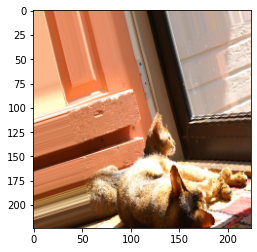

In [3]:
import matplotlib.pyplot as plt

x,y = train_generator.next()
print(x.std(), x.mean(), x.min(), x.max())
for i in range(0,1):
    image = x[i]
    print(y[i])
    plt.imshow(image)
    plt.show()

Данные подготовленны. Изображения с кошками имеют метку [0 1].

# Подготовка EfficientNet

In [6]:
# клонирование репозитория с моделями efficientnet
!git clone https://github.com/qubvel/efficientnet.git

Cloning into 'efficientnet'...
remote: Enumerating objects: 292, done.
remote: Total 292 (delta 0), reused 0 (delta 0), pack-reused 292
Receiving objects: 100% (292/292), 827.58 KiB | 2.94 MiB/s, done.
Resolving deltas: 100% (164/164), done.


Была произведена замена в /content/efficientnet/efficientnet/model.py в функциях get_swish и mb_conv_block.
    
        ...
                # replace swish to relu6
                # return backend.tf.nn.swish(x)
                return backend.tf.nn.relu6(x)
        ...

        ...
                # Squeeze and Excitation phase
                has_se = False
                if has_se:
        ...


Следуя [указаниям](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite):

Due to the requirements from edge devices, we mainly made the following changes based on the original EfficientNets.



*   Remove squeeze-and-excite (SE): SE are not well supported for some mobile accelerators.

* Replace all swish with RELU6: for easier post-quantization.
*   Fix the stem and head while scaling models up: for keeping models small and fast.



Создадим модель с фиксированным размер входного изображения и обучим её на имеющихся данных.

In [0]:
# загрузка ранее обученной сети
# import efficientnet.efficientnet.tfkeras as efn
# from tensorflow.keras.models import load_model

# model = load_model('/content/drive/My Drive/Machine Learning/Mobile/model_eff_b4.h5')

# Обучение EfficientNet

In [0]:
import efficientnet.efficientnet.tfkeras as efn 

model = efn.EfficientNetB4(weights=None, input_shape=(224, 224, 3), classes=2)
model.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
# проверка на отсутствие SE блока
for l in model.layers:
  if 'se' in l.name:
    print(l.name)

Во время обучения модель будет оцениваться с помощью метрики точности, так как классы сбалансированны и показатели точноти, полноты будут одинаковы.

In [0]:
# загрузка ранее обученной сети

import efficientnet.efficientnet.tfkeras as efn
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Machine Learning/Mobile/model_eff_b4.h5')

In [0]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', min_delta=0.01, patience=20, restore_best_weights=True)


def foo(epoch, lr):
  if epoch <= 10:
    return 3e-2
  elif epoch % 20 == 0:
    return lr*1/(0.9**19)
  else:
    return lr*0.9

lrs = LearningRateScheduler(foo)

tb = TensorBoard(log_dir='/content/drive/My Drive/Machine Learning/Mobile/logdir_b4_1/')

callbacks = [es, lrs, tb]

model.compile(loss=CategoricalCrossentropy(),
              optimizer='adam',
              metrics=[BinaryAccuracy()])

model.fit_generator(train_generator, validation_data=val_generator, epochs=10000, callbacks=callbacks)
model.save('/content/drive/My Drive/Machine Learning/Mobile/model_eff_b4_1.h5')

Epoch 1/10000
477/477 [==============================] - 759s 2s/step - loss: 0.3541 - binary_accuracy: 0.8498 - val_loss: 0.3701 - val_binary_accuracy: 0.8481 - lr: 0.0100
Epoch 2/10000
477/477 [==============================] - 753s 2s/step - loss: 0.3441 - binary_accuracy: 0.8530 - val_loss: 0.4417 - val_binary_accuracy: 0.8043 - lr: 0.0090
Epoch 3/10000
477/477 [==============================] - 753s 2s/step - loss: 0.3360 - binary_accuracy: 0.8600 - val_loss: 0.3263 - val_binary_accuracy: 0.8643 - lr: 0.0081
Epoch 4/10000
477/477 [==============================] - 772s 2s/step - loss: 0.3297 - binary_accuracy: 0.8615 - val_loss: 0.2917 - val_binary_accuracy: 0.8789 - lr: 0.0073
Epoch 5/10000
477/477 [==============================] - 769s 2s/step - loss: 0.3203 - binary_accuracy: 0.8634 - val_loss: 0.3163 - val_binary_accuracy: 0.8690 - lr: 0.0066
Epoch 6/10000
477/477 [==============================] - 764s 2s/step - loss: 0.3161 - binary_accuracy: 0.8688 - val_loss: 0.3569 - val

In [0]:
# очистка ненужных логов
!rm -R /content/drive/My\ Drive/Machine\ Learning/Mobile/logdir_b4_1

In [0]:
d = '/content/drive/My\ Drive/Machine\ Learning/Mobile/logdir'
# !kill 4449
%reload_ext tensorboard
%tensorboard --logdir {d}

In [37]:
model.evaluate_generator(test_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[0.2948067784309387, 0.8741549849510193]

Точность достигла 87%

# Конвертирование модели в TF Lite

In [6]:
! pip uninstall -y tensorflow
! pip install -q tf-nightly
! pip install -q tensorflow-model-optimization

Загрузка обученной сети и конвертация.

In [0]:
import efficientnet.efficientnet.tfkeras as efn
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Machine Learning/Mobile/model_eff_b4.h5', compile=False)

In [0]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=[BinaryAccuracy()])
# model.evaluate_generator(test_generator, verbose=1)

## TF Lite модель без квантования

In [28]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/drive/My Drive/Machine Learning/Mobile/tflite_model.tflite", "wb").write(tflite_model)

57424996

In [0]:
import numpy as np

test_images = []
test_labels = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    x,y = test_generator.next()
    test_images.extend(x)
    test_labels.extend(y)
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

In [38]:
test_images.shape, test_labels.shape

((1923, 224, 224, 3), (1923, 2))

[0. 1.] (224, 224, 3)


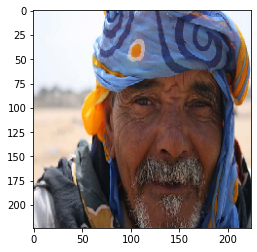

In [39]:
import matplotlib.pyplot as plt

for i, img in enumerate(test_images):
    print(test_labels[i], img.shape)
    plt.imshow(img)
    plt.show()
    break

In [0]:
import pandas as pd


def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)
    # if i ==10:
    #   break

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  diff = np.diff(test_labels[:,1])==np.diff(prediction_digits)
  accuracy = np.count_nonzero(diff == True) / len(diff)
  # accuracy = (prediction_digits == test_labels[:,1]).mean()
  return accuracy

In [77]:
len(np.diff(test_labels[:,1])==np.diff(test_labels[:,1]))

1922

In [89]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('TFLite test_accuracy:', test_accuracy)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.


TFLite test_accuracy: 0.7736732570239334


## Обучение с учётом квантования

In [5]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# функция указывающая к каким слоям не применять квантование
def apply_quantization_to_some_layer(layer):
  if '_drop' in layer.name:
    return layer
  try:
    if 'swish' in str(layer.activation):
      return layer
  except:
    pass
  return tfmot.quantization.keras.quantize_annotate_layer(layer)

annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_some_layer,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_stem_conv (QuantizeWrappe (None, 112, 112, 48) 1393        quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_stem_bn (QuantizeWrapper) (None, 112, 112, 48) 195         quant_stem_conv[0][0]            
____________________________________________________________________________________

Обучение с учётом квантования

In [7]:
from tensorflow.keras.optimizers import Adam

quant_aware_model.compile(optimizer=Adam(1e-3),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=[BinaryAccuracy()])
quant_aware_model.fit_generator(train_generator, validation_data=val_generator, epochs=1)

 51/480 [==>...........................] - ETA: 1:38:15 - loss: 0.7143 - binary_accuracy: 0.4969

KeyboardInterrupt: ignored

In [0]:
_, acc = model.evaluate_generator(test_generator)
_, q_acc = quant_aware_model.evaluate_generator(test_generator)

print('Baseline test accuracy:', acc)
print('Quant test accuracy:', q_acc)

Квантование

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_aware_tflite_model = converter.convert()

Оценка точности

In [0]:
test_images = []
test_labels = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    x,y = test_generator.next()
    test_images.append(x[0])
    test_labels.append(y[0])
    batch_index = batch_index + 1

test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

In [0]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In [0]:
interpreter = tf.lite.Interpreter(model_content=quantized_aware_tflite_model)
interpreter.allocate_tensors()

q_acc = evaluate_model(interpreter)

print('Quant aware training TFLite test_accuracy:', q_acc)

In [0]:
open("quant_aware_model.tflite", "wb").write(quantized_aware_tflite_model)

## Квантование обученной сети (до int8)

Подготовка данных для тестирования

In [0]:
import numpy as np

test_images = []
test_labels = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    x,y = test_generator.next()
    test_images.extend(x)
    test_labels.extend(y)
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

Была произведена замена в /content/efficientnet/efficientnet/model.py. Добавлен метод 
def _get_trainable_state():
      pass

Квантование производилось с учётом поступления в сеть вещественных значений.

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_gen():
  for img in test_images:
    yield [np.expand_dims(img, axis=0).astype(np.float32)]
    
converter.representative_dataset = representative_dataset_gen

tflite_quant_model = converter.convert()
open("/content/drive/My Drive/Machine Learning/Mobile/int8_model.tflite", "wb").write(tflite_quant_model)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpy1k4eruo/assets


16639728

In [0]:
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32) 
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  diff = np.diff(test_labels[:,1])==np.diff(prediction_digits)
  accuracy = np.count_nonzero(diff == True) / len(diff)
  return accuracy

In [0]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant int8 test_accuracy:', test_accuracy)

Evaluated on 0 results so far.


## Квантование обученной сети (до float16)

In [12]:
import tensorflow as tf

float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_converter.optimizations = [tf.lite.Optimize.DEFAULT]
float_converter.target_spec.supported_types = [tf.dtypes.float16]
float_tflite_model = float_converter.convert()
open("/content/drive/My Drive/Machine Learning/Mobile/float16_model.tflite", "wb").write(float_tflite_model)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpn6n7n_68/assets


28805872

In [0]:

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)
    # if i ==10:
    #   break

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  diff = np.diff(test_labels[:,1])==np.diff(prediction_digits)
  accuracy = np.count_nonzero(diff == True) / len(diff)
  # accuracy = (prediction_digits == test_labels[:,1]).mean()
  return accuracy

In [19]:
interpreter = tf.lite.Interpreter(model_content=float_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant float test_accuracy:', test_accuracy)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.


Quant float test_accuracy: 0.7726326742976066
